## Environment setup

In [9]:
!pip install roboflow

from roboflow import Roboflow
import cv2
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from IPython.display import Image
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import cv2
import colorsys
import random

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [10]:
import os

In [11]:
import numpy as np
import os, random, tensorflow as tf

seed_value=1234
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [12]:
!nvidia-smi

Tue Mar 11 23:50:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P3              8W /   45W |      24MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
!pip install git+https://github.com/sunsmarterjie/yolov12.git
!pip install roboflow
!pip install supervision
!pip install huggingface_hub
import cv2
from ultralytics import YOLO
import supervision as sv

  Cloning https://github.com/sunsmarterjie/yolov12.git to c:\users\manus\appdata\local\temp\pip-req-build-mlncbqfz
  Resolved https://github.com/sunsmarterjie/yolov12.git to commit e011b1012ccbd6f208afe29dc21e251920c76784
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/sunsmarterjie/yolov12.git 'C:\Users\Manus\AppData\Local\Temp\pip-req-build-mlncbqfz'


FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


In [14]:
current_path = os.getcwd()
HOME = os.path.abspath(os.path.join(current_path, '..'))
print(f"HOME path: {HOME}")

HOME path: c:\Manus\DL_project\project


In [15]:
dataset_location = f"{HOME}\\dataset_plates"

## Evaluate fine-tuned YOLOv12 model

In [17]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['plates']

In [18]:
import os

model_path = f"{HOME}\\train_model\\runs\\detect\\train\\weights\\best.pt"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = YOLO(model_path)


## Run inference with fine-tuned YOLOv12 model

In [20]:
def histogram_equalization(image):
    """
    ทำ Histogram Equalization บนช่อง Value (V) ของภาพ HSV
    """
    # แปลงจาก RGB เป็น HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # แยกช่อง Hue, Saturation, Value
    h, s, v = cv2.split(hsv)

    # ทำ Histogram Equalization บนช่อง V (ความสว่าง)
    v_eq = cv2.equalizeHist(v)

    # รวมกลับเป็น HSV
    hsv_eq = cv2.merge([h, s, v_eq])
    # แปลงกลับเป็น RGB
    image_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

    return image_eq

def white_balance_simple(image):
    """
    Simple white balance by scaling channels based on average intensity
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate the mean for each channel
    mean_r = np.mean(image_float[:,:,0])
    mean_g = np.mean(image_float[:,:,1])
    mean_b = np.mean(image_float[:,:,2])

    # Calculate scaling factors
    scale_r = 128 / mean_r if mean_r > 0 else 1
    scale_g = 128 / mean_g if mean_g > 0 else 1
    scale_b = 128 / mean_b if mean_b > 0 else 1

    # Scale each channel
    image_float[:,:,0] *= scale_r
    image_float[:,:,1] *= scale_g
    image_float[:,:,2] *= scale_b

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)

    return image_balanced

def white_balance_gray_world(image):
    """
    Gray World Assumption white balance method
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate average of each channel
    r_avg = np.mean(image_float[:,:,0])
    g_avg = np.mean(image_float[:,:,1])
    b_avg = np.mean(image_float[:,:,2])

    # Calculate the overall average
    avg = (r_avg + g_avg + b_avg) / 3

    # Calculate scaling factors
    r_scale = avg / r_avg if r_avg > 0 else 1
    g_scale = avg / g_avg if g_avg > 0 else 1
    b_scale = avg / b_avg if b_avg > 0 else 1

    # Apply scaling
    image_float[:,:,0] *= r_scale
    image_float[:,:,1] *= g_scale
    image_float[:,:,2] *= b_scale

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)
    return image_balanced

In [21]:
def detect_color_from_bbox(image, bbox, crop_ratio=0.8):
    """
    Detect average color from bounding box using advanced color analysis

    Args:
    - image: PIL Image
    - bbox: (xmin, ymin, xmax, ymax)
    - crop_ratio: Ratio of bounding box to analyze (default 0.8)

    Returns:
    - Tuple of (hue, saturation, value)
    """
    xmin, ymin, xmax, ymax = bbox
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    cropped_img = np.array(cropped_img)

    # Convert to HSV
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)

    # Apply median blur to reduce noise
    hsv_img = cv2.medianBlur(hsv_img, 5)

    # Crop center of the image
    h, w, _ = hsv_img.shape
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    y_offset, x_offset = (h - new_h) // 2, (w - new_w) // 2
    cropped_center = hsv_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

    # Calculate median values
    avg_hue = np.median(cropped_center[:, :, 0])
    avg_sat = np.median(cropped_center[:, :, 1])
    avg_val = np.median(cropped_center[:, :, 2])

    return avg_hue, avg_sat, avg_val

def identify_color(avg_hue, avg_sat, avg_val):
    """
    Identify color based on HSV values

    Args:
    - avg_hue: Hue value (0-180 in OpenCV)
    - avg_sat: Saturation value (0-255)
    - avg_val: Value/Brightness value (0-255)

    Returns:
    - Color name as string
    """
    # Convert OpenCV HSV to standard HSV
    hue = avg_hue * 2  # OpenCV uses 0-180, standard HSV uses 0-360
    sat = avg_sat / 255 * 100  # Convert to percentage
    val = avg_val / 255 * 100  # Convert to percentage

    # Print debug information
    print(f"🔍 Hue: {hue:.2f}, Saturation: {sat:.2f}%, Value: {val:.2f}%")

    # Check for white, black, or gray conditions
    if val < 20:
        return "Black"
    if sat < 20 or val > 90:
        return "White"

    # Detailed color mapping
    if (hue >= 330 or hue <= 30):  # Red
        return "Red"
    elif 30 < hue < 90:  # Yellow to Green
        if hue < 60:
            return "Yellow"
        else:
            return "Green"
    elif 90 <= hue < 150:  # Cyan to Blue
        if hue < 120:
            return "Cyan"
        else:
            return "Blue"
    elif 150 <= hue < 270:  # Blue to Purple
        if hue < 210:
            return "Blue"
        else:
            return "Purple"
    elif 270 <= hue < 330:  # Magenta to Red
        return "Red2"

    return "Unknown"
# Main processing function
def process_image(image_path, model, sv):
    # Open and preprocess image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    # image = Image.fromarray(white_balance_gray_world(np.array(image)))

    # Detect objects
    results = model(image, verbose=False)[0]
    # ปรับค่า IoU threshold ในขั้นตอน NMS
    detections = sv.Detections.from_ultralytics(results).with_nms()


    # Annotate image
    box_annotator = sv.BoxAnnotator(thickness=5)
    label_annotator = sv.LabelAnnotator()
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Count colors
    dict_count = {}
    for i, box in enumerate(detections.xyxy):
        avg_color = detect_color_from_bbox(image, box)
        color = identify_color(*avg_color)

        # Count colors
        dict_count[color] = dict_count.get(color, 0) + 1

    # Print results
    for key, value in dict_count.items():
        print(f"{key}: {value}")

    print(f"Number of detections: {len(detections.xyxy)}")
    print(f"Number of boxes drawn: {len(detections)}")

    # Plot image
    sv.plot_image(annotated_image)

    return dict_count, annotated_image

# Call the processing function

# result_count, result_image = process_image(image_path, model, sv)

In [22]:
# Main processing function
def process_image(image_path, model, sv):
    # Open and preprocess image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    # image = Image.fromarray(white_balance_gray_world(np.array(image)))

    # Detect objects
    results = model(image, verbose=False)[0]
    # ปรับค่า IoU threshold ในขั้นตอน NMS
    detections = sv.Detections.from_ultralytics(results).with_nms()


    # Annotate image
    box_annotator = sv.BoxAnnotator(thickness=5)
    label_annotator = sv.LabelAnnotator()
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Count colors
    dict_count = {}
    for i, box in enumerate(detections.xyxy):
        avg_color = detect_color_from_bbox(image, box)
        color = identify_color(*avg_color)

        # Count colors
        dict_count[color] = dict_count.get(color, 0) + 1

    # Print results
    for key, value in dict_count.items():
        print(f"{key}: {value}")

    print(f"Number of detections: {len(detections.xyxy)}")
    print(f"Number of boxes drawn: {len(detections)}")

    # Plot image
    sv.plot_image(annotated_image)

    return dict_count, annotated_image

# Call the processing function

# result_count, result_image = process_image(image_path, model, sv)

## predict your picture

🔍 Hue: 352.00, Saturation: 56.08%, Value: 64.71%
🔍 Hue: 352.00, Saturation: 55.69%, Value: 68.24%
🔍 Hue: 354.00, Saturation: 93.73%, Value: 16.47%
🔍 Hue: 2.00, Saturation: 50.20%, Value: 27.45%
🔍 Hue: 354.00, Saturation: 29.41%, Value: 24.71%
🔍 Hue: 8.00, Saturation: 52.55%, Value: 25.49%
🔍 Hue: 2.00, Saturation: 96.47%, Value: 13.73%
🔍 Hue: 196.00, Saturation: 29.80%, Value: 29.80%
🔍 Hue: 4.00, Saturation: 86.67%, Value: 24.31%
🔍 Hue: 354.00, Saturation: 95.29%, Value: 16.86%
🔍 Hue: 196.00, Saturation: 18.82%, Value: 91.37%
🔍 Hue: 208.00, Saturation: 33.73%, Value: 25.88%
🔍 Hue: 202.00, Saturation: 30.59%, Value: 30.98%
🔍 Hue: 30.00, Saturation: 15.69%, Value: 40.00%
🔍 Hue: 356.00, Saturation: 96.86%, Value: 14.51%
🔍 Hue: 204.00, Saturation: 96.08%, Value: 14.12%
🔍 Hue: 200.00, Saturation: 16.08%, Value: 48.24%
🔍 Hue: 356.00, Saturation: 93.73%, Value: 22.75%
Red: 7
Black: 5
Blue: 3
White: 3
Number of detections: 18
Number of boxes drawn: 18


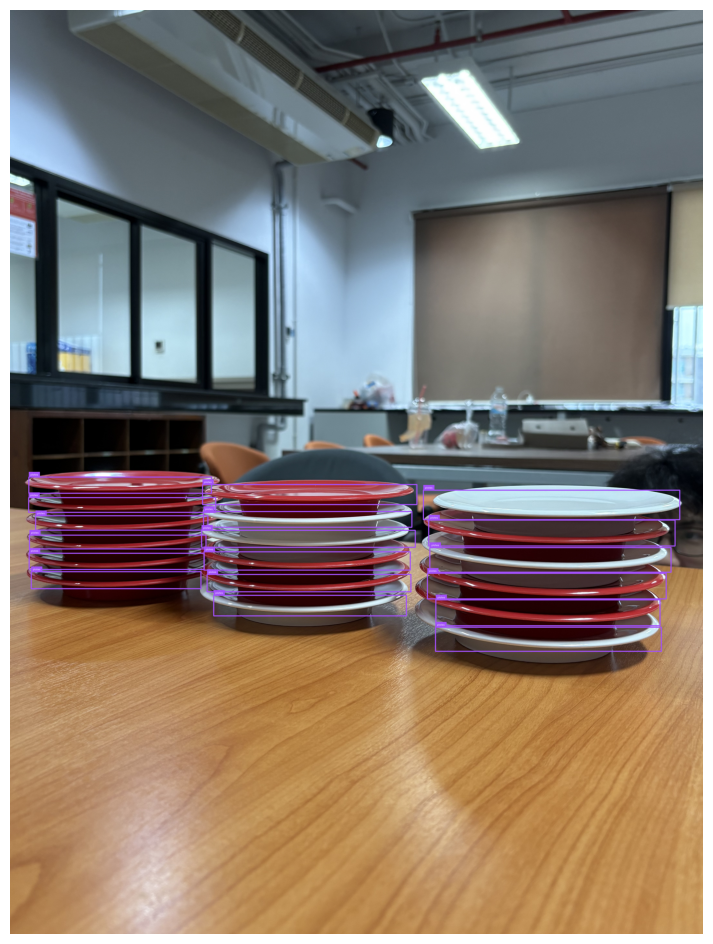

In [ ]:
#select your picture to predict
image_path = "C:\Manus\DL_project\project\IMG_2042.JPG"
result_count, result_image = process_image(image_path, model, sv)

## predict dataset test

🔍 Hue: 356.00, Saturation: 80.00%, Value: 59.80%
🔍 Hue: 356.00, Saturation: 78.82%, Value: 52.94%
🔍 Hue: 4.00, Saturation: 82.35%, Value: 50.98%
🔍 Hue: 356.00, Saturation: 84.31%, Value: 51.76%
🔍 Hue: 358.00, Saturation: 77.25%, Value: 62.75%
🔍 Hue: 2.00, Saturation: 79.22%, Value: 49.41%
🔍 Hue: 356.00, Saturation: 77.25%, Value: 65.49%
🔍 Hue: 10.00, Saturation: 76.47%, Value: 53.73%
🔍 Hue: 356.00, Saturation: 77.65%, Value: 53.14%
🔍 Hue: 356.00, Saturation: 72.94%, Value: 64.51%
🔍 Hue: 60.00, Saturation: 4.31%, Value: 68.24%
🔍 Hue: 356.00, Saturation: 71.37%, Value: 62.75%
🔍 Hue: 190.00, Saturation: 5.49%, Value: 66.27%
🔍 Hue: 142.00, Saturation: 8.63%, Value: 72.35%
🔍 Hue: 48.00, Saturation: 5.10%, Value: 65.10%
🔍 Hue: 2.00, Saturation: 66.27%, Value: 62.35%
🔍 Hue: 109.00, Saturation: 6.67%, Value: 65.10%
🔍 Hue: 180.00, Saturation: 7.84%, Value: 71.37%
Red: 12
White: 6
Number of detections: 18
Number of boxes drawn: 18


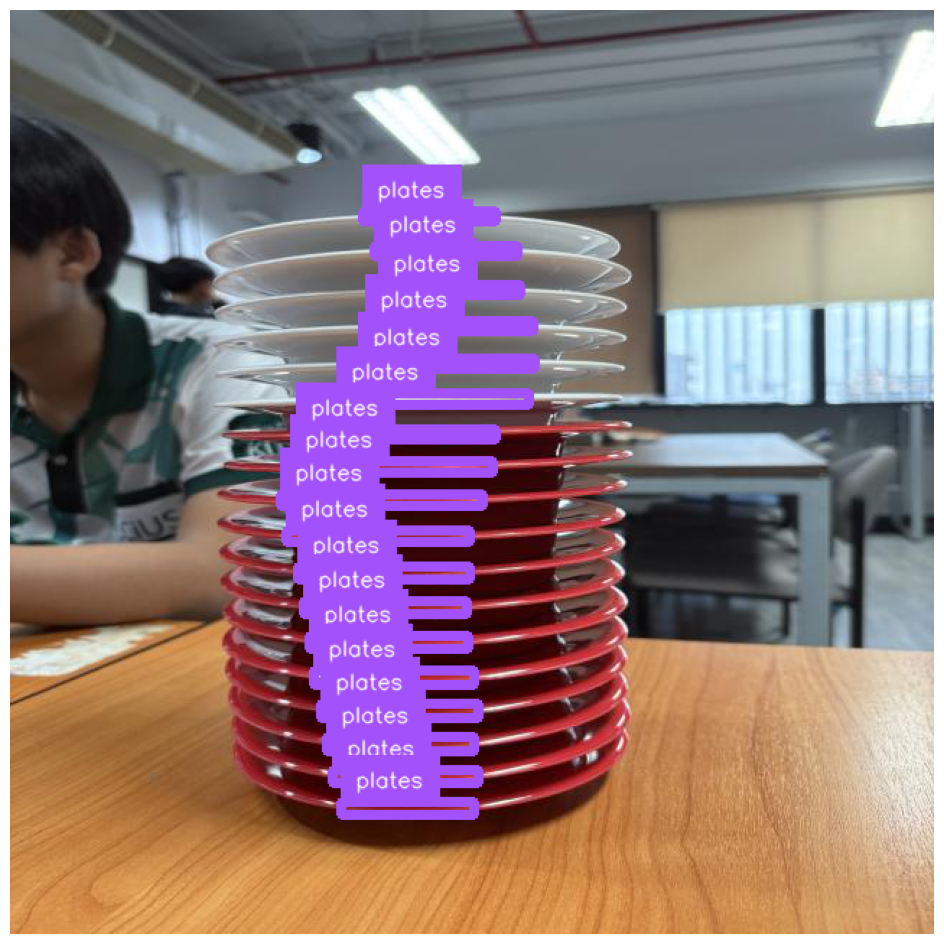

In [23]:
i = random.randint(0, len(ds)-1)

image_path, image, target = ds[i]

result_count, result_image = process_image(image_path, model, sv)